In [1]:
import requests
import os
import numpy as np
import matplotlib
from simple_dl import Model, Layer, FinalLayer, Activation
%matplotlib ipympl

In [2]:
headers = {
    "User-Agent": "Mozilla/5.0 (X11; Linux x86_64; rv:10.0) Gecko/20100101 Firefox/10.0"
}
request_opts = {
    "headers": headers,
    "params": {"raw":"true"}
}

In [3]:
data_dir = "../data"
os.makedirs(data_dir, exist_ok=True)

base_url = "https://storage.googleapis.com/tensorflow/tf-keras-datasets/"
fname = "mnist.npz"
fpath = os.path.join(data_dir, fname)
if not os.path.exists(fpath):
    print('Downloading file: ' + fname)
    resp = requests.get(base_url + fname, stream = True, **request_opts)
    resp.raise_for_status()
    with open(fpath, "wb") as fh:
        for chunk in resp.iter_content(chunk_size=128):
            fh.write(chunk)

In [4]:
data_file = np.load(fpath)
x_train = data_file["x_train"]
x_test = data_file["x_test"]
y_train = data_file["y_train"]
y_test = data_file["y_test"]
data_file.close()

In [5]:
x_train = x_train.reshape(len(x_train), 28 * 28)
x_test = x_test.reshape(len(x_test), 28 * 28)

In [6]:
sample_size = int(len(x_train))
test_split = 5 * sample_size // 6
seed = 1234
rng = np.random.default_rng(seed=seed)
index = rng.choice(len(x_train), sample_size)
train_sample_X = x_train[index[:test_split]]
val_sample_X = x_train[index[test_split:]]
train_sample_y = y_train[index[:test_split]]
val_sample_y = y_train[index[test_split:]]

In [7]:
train_sample_X = train_sample_X * 1.0 / 255
val_sample_X = val_sample_X * 1.0 / 255
test_sample_X = x_test * 1.0 / 255

In [8]:
def one_hot_encoding(labels, dim=10):
    one_hot_labels = labels[..., None] == np.arange(dim)[None]
    return one_hot_labels.astype(np.float64)

In [9]:
train_sample_labels = one_hot_encoding(train_sample_y)
val_sample_labels = one_hot_encoding(val_sample_y)
test_sample_labels = one_hot_encoding(y_test)

In [10]:
learning_rate = 0.0005
epochs = 20
pixels_per_image = 28 * 28
num_labels = 10
batch_size = 100
dropout = 0.45
hidden_layer_sizes = [200,50]

In [11]:
model = Model(rng=rng,
              training_data_X=train_sample_X,
              training_data_y=train_sample_labels,
              val_data_X=val_sample_X,
              val_data_y=val_sample_labels,
              objective_function='categoricalcrossentropy',
              learning_rate=learning_rate,
              epochs=epochs,
              batch_size=batch_size
             )

In [12]:
for output_size in hidden_layer_sizes:
    model.add_layer(output_size=output_size,
                    func_name='relu',
                    dropout=dropout
                   )
model.add_final_layer()

In [13]:
model.run()

Epoch: 0
  Training loss:          25.230
  Training accuracy:      0.218
  Validation loss:        24.512
  Validation accuracy:    0.351

Epoch: 1
  Training loss:          21.524
  Training accuracy:      0.419
  Validation loss:        21.039
  Validation accuracy:    0.491

Epoch: 2
  Training loss:          19.581
  Training accuracy:      0.530
  Validation loss:        19.721
  Validation accuracy:    0.573

Epoch: 3
  Training loss:          18.611
  Training accuracy:      0.595
  Validation loss:        19.519
  Validation accuracy:    0.620

Epoch: 4
  Training loss:          18.391
  Training accuracy:      0.633
  Validation loss:        19.655
  Validation accuracy:    0.644

Epoch: 5
  Training loss:          18.403
  Training accuracy:      0.662
  Validation loss:        19.669
  Validation accuracy:    0.669

Epoch: 6
  Training loss:          18.406
  Training accuracy:      0.688
  Validation loss:        19.795
  Validation accuracy:    0.699

Epoch: 7
  Training 

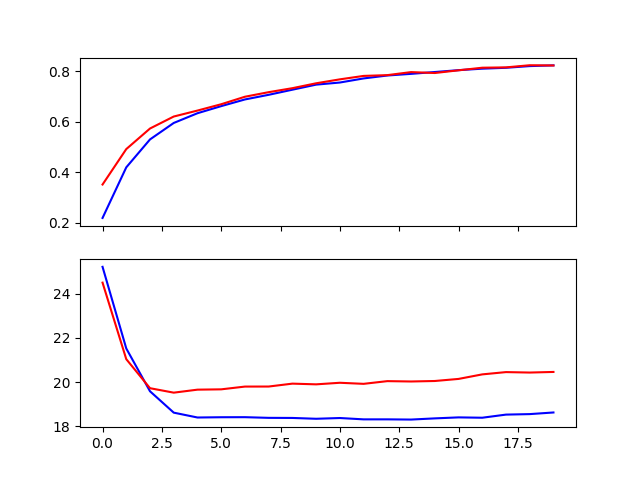

In [19]:
from matplotlib import pyplot as plt
from matplotlib.pyplot import subplots
fig, axs = subplots(2, sharex='col')
x = np.arange(epochs)
y1 = model.training_acc
y2 = model.training_loss
y3 = model.val_acc
y4 = model.val_loss
axs[0].plot(x,y1,'b-')
axs[1].plot(x,y2,'b-')
axs[0].plot(x,y3,'r-')
axs[1].plot(x,y4,'r-')

In [15]:
layer1 = model.layers[0]
layer2 = model.layers[1]
layer3 = model.layers[2]

In [16]:
layer1.weights.shape,layer2.weights.shape, layer3.weights.shape


((784, 200), (200, 50), (50, 10))

In [17]:
U1,S1,V1 = np.linalg.svd(layer1.weights)
U2, S2, V2 = np.linalg.svd(layer2.weights)
U3, S3, V3 = np.linalg.svd(layer3.weights)

In [18]:
S1,S2,S3

(array([2.93967529, 2.75873632, 2.66213595, 2.54752755, 2.44603926,
        2.42064022, 2.40136518, 2.37236114, 2.34388857, 2.32633732,
        2.31103743, 2.29682584, 2.28483343, 2.24980024, 2.23013101,
        2.22106728, 2.21723187, 2.18684446, 2.17524785, 2.16392214,
        2.14816955, 2.14312736, 2.12930632, 2.11995963, 2.10824738,
        2.10304105, 2.09794341, 2.08861337, 2.07941174, 2.06732867,
        2.06302767, 2.04413804, 2.03588166, 2.03181125, 2.0180624 ,
        2.01085162, 2.00337081, 1.99494229, 1.98470702, 1.9755784 ,
        1.96894838, 1.96613956, 1.96246351, 1.94846978, 1.93625534,
        1.92548174, 1.92227952, 1.91979651, 1.90753181, 1.89756258,
        1.89160397, 1.88447395, 1.87817877, 1.8769453 , 1.87146413,
        1.8559019 , 1.84942286, 1.83776151, 1.82865945, 1.81781243,
        1.80773076, 1.80267112, 1.79671709, 1.78935462, 1.78533955,
        1.78486   , 1.77545366, 1.76971202, 1.7651766 , 1.75411013,
        1.74422325, 1.73629567, 1.73374315, 1.72